In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image
from nilearn import signal
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiMapsMasker
from nilearn.plotting import plot_roi, plot_stat_map,plot_epi, plot_img
from nilearn import datasets, surface, plotting
from nilearn.image import new_img_like
import nilearn as nl 
import nibabel as nib
from nilearn import datasets
import os
import glob
from nltools import Brain_Data
import seaborn as sns
from scipy.stats import pearsonr 
from flexitext import flexitext


# Homemade functions

In [2]:
def fit_mask_get_mean(current_mask, sub_data):
    try:
        fit_2_mask = current_mask.fit_transform(sub_data)
        mean_score = np.mean(fit_2_mask)
    except ValueError:
        mean_score = 0
    return mean_score

In [3]:
# Function for plotting brain maps. 

fsaverage = datasets.fetch_surf_fsaverage()

def plot_brainmaps_results(COC_AVG_file, COC_STD_file, PLA_AVG_file, PLA_STD_file, titles):

    texture_pial_right_COC_AVG = surface.vol_to_surf(COC_AVG_file.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=10, interpolation="nearest")
    texture_pial_left_COC_AVG = surface.vol_to_surf(COC_AVG_file.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=10, interpolation="nearest")

    texture_pial_right_PLA_AVG = surface.vol_to_surf(PLA_AVG_file.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=10, interpolation="nearest")
    texture_pial_left_PLA_AVG = surface.vol_to_surf(PLA_AVG_file.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=10, interpolation="nearest")

    texture_pial_right_COC_STD = surface.vol_to_surf(COC_STD_file.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=10, interpolation="nearest")
    texture_pial_left_COC_STD = surface.vol_to_surf(COC_STD_file.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=10, interpolation="nearest")

    texture_pial_right_PLA_STD = surface.vol_to_surf(PLA_STD_file.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=10, interpolation="nearest")
    texture_pial_left_PLA_STD = surface.vol_to_surf(PLA_STD_file.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=10, interpolation="nearest")

    fig, axs = plt.subplots(4, 2, figsize=(10, 16), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 

    # Plot COC AVG brain maps on first row.
    axs[0, 0].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[0, 0].yaxis.set_tick_params(labelleft=False, left=False)
    axs[0, 1].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[0, 1].yaxis.set_tick_params(labelleft=False, left=False)
    fig.text(x=0.40, y=0.85, s=titles[0], fontdict={"fontsize": 20})
    plotting.plot_surf(fsaverage.pial_left, texture_pial_left_COC_AVG, colorbar=True, cmap='viridis', axes=axs[0, 0]) 
    plotting.plot_surf(fsaverage.pial_right, texture_pial_right_COC_AVG, colorbar=True, cmap='viridis', axes=axs[0, 1]) 

    # Plot PLA AVG brain maps on second row.
    axs[1, 0].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[1, 0].yaxis.set_tick_params(labelleft=False, left=False)
    axs[1, 1].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[1, 1].yaxis.set_tick_params(labelleft=False, left=False)
    fig.text(x=0.40, y=0.65, s=titles[1], fontdict={"fontsize": 20})
    plotting.plot_surf(fsaverage.pial_left, texture_pial_left_PLA_AVG, colorbar=True, cmap='viridis', axes=axs[1, 0]) 
    plotting.plot_surf(fsaverage.pial_right, texture_pial_right_PLA_AVG, colorbar=True, cmap='viridis', axes=axs[1, 1]) 

    # Plot COC STD brain maps on third row.
    axs[2, 0].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[2, 0].yaxis.set_tick_params(labelleft=False, left=False)
    axs[2, 1].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[2, 1].yaxis.set_tick_params(labelleft=False, left=False)
    fig.text(x=0.40, y=0.45, s=titles[2], fontdict={"fontsize": 20})
    plotting.plot_surf(fsaverage.pial_left, texture_pial_left_COC_STD, colorbar=True, cmap='viridis', axes=axs[2, 0]) 
    plotting.plot_surf(fsaverage.pial_right, texture_pial_right_COC_STD, colorbar=True, cmap='viridis', axes=axs[2, 1]) 

    # Plot PLS STD brain maps on fourth row.
    axs[3, 0].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[3, 0].yaxis.set_tick_params(labelleft=False, left=False)
    axs[3, 1].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[3, 1].yaxis.set_tick_params(labelleft=False, left=False)
    fig.text(x=0.40, y=0.25, s=titles[3], fontdict={"fontsize": 20})
    plotting.plot_surf(fsaverage.pial_left, texture_pial_left_PLA_STD, colorbar=True, cmap='viridis', axes=axs[3, 0]) 
    plotting.plot_surf(fsaverage.pial_right, texture_pial_right_PLA_STD, colorbar=True, cmap='viridis', axes=axs[3, 1]) 

    plt.show()


In [4]:
# Function for plotting brain maps of change score files. 

def plotting_brainmaps_change(AVG_Change_file, STD_Change_file, Change_title):

    texture_pial_right_AVG_Change = surface.vol_to_surf(AVG_Change_file.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=10, interpolation="nearest")
    texture_pial_left_AVG_Change = surface.vol_to_surf(AVG_Change_file.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=10, interpolation="nearest")

    texture_pial_right_STD_Change = surface.vol_to_surf(STD_Change_file.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=10, interpolation="nearest")
    texture_pial_left_STD_Change = surface.vol_to_surf(STD_Change_file.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=10, interpolation="nearest")

    fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 

    # Plot AVG Change brain maps on first row.
    axs[0, 0].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[0, 0].yaxis.set_tick_params(labelleft=False, left=False)
    axs[0, 1].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[0, 1].yaxis.set_tick_params(labelleft=False, left=False)
    fig.text(x=0.38, y=0.85, s=Change_title[0], fontdict={"fontsize": 15})
    plotting.plot_surf(fsaverage.pial_left, texture_pial_left_AVG_Change, colorbar=True, cmap='viridis', axes=axs[0, 0]) 
    plotting.plot_surf(fsaverage.pial_right, texture_pial_right_AVG_Change, colorbar=True, cmap='viridis', axes=axs[0, 1]) 

    # Plot STD Change brain maps on first row.
    axs[1, 0].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[1, 0].yaxis.set_tick_params(labelleft=False, left=False)
    axs[1, 1].xaxis.set_tick_params(labelbottom=False, bottom=False)
    axs[1, 1].yaxis.set_tick_params(labelleft=False, left=False)
    fig.text(x=0.38, y=0.42, s=Change_title[1], fontdict={"fontsize": 15})
    plotting.plot_surf(fsaverage.pial_left, texture_pial_left_STD_Change, colorbar=True, cmap='viridis', axes=axs[1, 0]) 
    plotting.plot_surf(fsaverage.pial_right, texture_pial_right_STD_Change, colorbar=True, cmap='viridis', axes=axs[1, 1]) 
    
    plt.show()


In [5]:
# Fuction to create scatter plots with corr.
def plot_correlations(all_atlas_haseen_data, correlations_list, type_of_score):

    fig, ax = plt.subplots(5, 2, figsize=(15, 30))

    regplot_D1 = sns.regplot(data=all_atlas_haseen_data, x="Change_scores", y="D1_density", ax=ax[0, 0])
    title1 = "Corr <color:blue>D1 </>and AAL " + type_of_score
    flexitext(0.2, 1.05, title1, va="top", ax=ax[0, 0])
    r_value1 = "<weight:bold, size:10>r="+str(round(correlations_list[0][0], 5))+"</>"
    flexitext(0.85, 0.9, r_value1, ha="center", ax=ax[0, 0])

    regplot_D2_s = sns.regplot(data=all_atlas_haseen_data, x="Change_scores", y="D2_s_density", ax=ax[0, 1])
    title2 = "Corr <color:blue>D2_s </>and AAL " + type_of_score
    flexitext(0.2, 1.05, title2, va="top", ax=ax[0, 1])
    r_value2 = "<weight:bold, size:10>r="+str(round(correlations_list[1][0], 5))+"</>"
    flexitext(0.85, 0.9, r_value2, ha="center", ax=ax[0, 1])

    regplot_D2_sd = sns.regplot(data=all_atlas_haseen_data, x="Change_scores", y="D2_sd_density", ax=ax[1, 0])
    title3 = "Corr <color:blue>D2_s </>and AAL " + type_of_score
    flexitext(0.2, 1.05, title3, va="top", ax=ax[1, 0])
    r_value3 = "<weight:bold, size:10>r="+str(round(correlations_list[2][0], 5))+"</>"
    flexitext(0.85, 0.9, r_value3, ha="center", ax=ax[1, 0])

    regplot_DAT = sns.regplot(data=all_atlas_haseen_data, x="Change_scores", y="DAT_density", ax=ax[1, 1])
    title4 = "Corr <color:blue>DAT </>and AAL " + type_of_score
    flexitext(0.2, 1.05, title4, va="top", ax=ax[1, 1])
    r_value4 = "<weight:bold, size:10>r="+str(round(correlations_list[3][0], 5))+"</>"
    flexitext(0.85, 0.9, r_value4, ha="center", ax=ax[1, 1])

    regplot_mGlu = sns.regplot(data=all_atlas_haseen_data, x="Change_scores", y="mGlu_density", ax=ax[2, 0], color="green")
    title5 = "Corr <color:green>mGlu </>and AAL " + type_of_score
    flexitext(0.2, 1.05, title5, va="top", ax=ax[2, 0])
    r_value5 = "<weight:bold, size:10>r="+str(round(correlations_list[4][0], 5))+"</>"
    flexitext(0.85, 0.9, r_value5, ha="center", ax=ax[2, 0])

    regplot_NMDA = sns.regplot(data=all_atlas_haseen_data, x="Change_scores", y="NMDA_density", ax=ax[2, 1], color="green")
    title6 = "Corr <color:green>NMDA </>and AAL " + type_of_score
    flexitext(0.2, 1.05, title6, va="top", ax=ax[2, 1])
    r_value6 = "<weight:bold, size:10>r="+str(round(correlations_list[5][0], 5))+"</>"
    flexitext(0.85, 0.9, r_value6, ha="center", ax=ax[2, 1])

    regplot_mGlu = sns.regplot(data=all_atlas_haseen_data, x="Change_scores", y="GABAa_density", ax=ax[3, 0], color="red") 
    title7 = "Corr <color:red>GABAa </>and AAL " + type_of_score
    flexitext(0.2, 1.05, title7, va="top", ax=ax[3, 0])
    r_value7 = "<weight:bold, size:10>r="+str(round(correlations_list[6][0], 5))+"</>"
    flexitext(0.85, 0.9, r_value7, ha="center", ax=ax[3, 0])

    regplot_NMDA = sns.regplot(data=all_atlas_haseen_data, x="Change_scores", y="GABAbz_density", ax=ax[3, 1], color="red")
    title8 = "Corr <color:red>GABAbz </>and AAL " + type_of_score
    flexitext(0.2, 1.05, title8, va="top", ax=ax[3, 1])
    r_value8 = "<weight:bold, size:10>r="+str(round(correlations_list[7][0], 5))+"</>"
    flexitext(0.85, 0.9, r_value8, ha="center", ax=ax[3, 1])

    regplot_NAT = sns.regplot(data=all_atlas_haseen_data, x="Change_scores", y="NAT_density", ax=ax[4, 0], color="gray")
    title9 = "Corr <color:gray>NAT </>and AAL " + type_of_score
    flexitext(0.2, 1.05, title9, va="top", ax=ax[4, 0])
    r_value9 = "<weight:bold, size:10>r="+str(round(correlations_list[8][0], 5))+"</>"
    flexitext(0.85, 0.9, r_value9, ha="center", ax=ax[4, 0])

    plt.show()
    

# Open Hassen Neurotransmitters Maps

In [6]:
# Now open a directory/folder 
fd = os.open("/Users/luisalvarez/Documents", os.O_RDONLY)

# Use os.fchdir() method to change the dir/folder
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents


### Dopamine Maps

In [7]:
# Define paths to Hassen files for dopamine neurotransmitters. 
path_D1 = "GitHub/hansen_receptors/data/PET_nifti_images/D1_SCH23390_hc13_kaller.nii"
path_D2_smith = "GitHub/hansen_receptors/data/PET_nifti_images/D2_flb457_hc37_smith.nii.gz"
path_D2_sandiego = "GitHub/hansen_receptors/data/PET_nifti_images/D2_flb457_hc55_sandiego.nii.gz"
path_DAT = "GitHub/hansen_receptors/data/PET_nifti_images/DAT_fpcit_hc174_dukart_spect.nii"

# Create Brain_data objects for each file. 
D1_map = Brain_Data(path_D1).to_nifti()
D2_smith_map = Brain_Data(path_D2_smith).to_nifti()
D2_sandiego_map = Brain_Data(path_D2_sandiego).to_nifti()
DAT_map = Brain_Data(path_DAT).to_nifti()

# Check the shape of each file.
print("D1_map shape: " + str(D1_map.shape))
print("D2_smith_map shape: " + str(D2_smith_map.shape))
print("D2_sandiego_map shape: " + str(D2_sandiego_map.shape))
print("DAT_map shape: " + str(DAT_map.shape))


D1_map shape: (91, 109, 91)
D2_smith_map shape: (91, 109, 91)
D2_sandiego_map shape: (91, 109, 91)
DAT_map shape: (91, 109, 91)


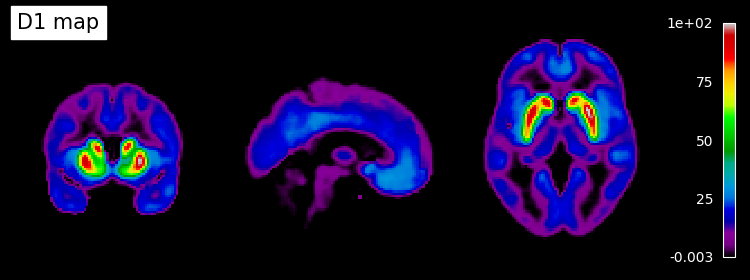

In [8]:
# Visualize the D1 map.
plot_epi(D1_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="D1 map")


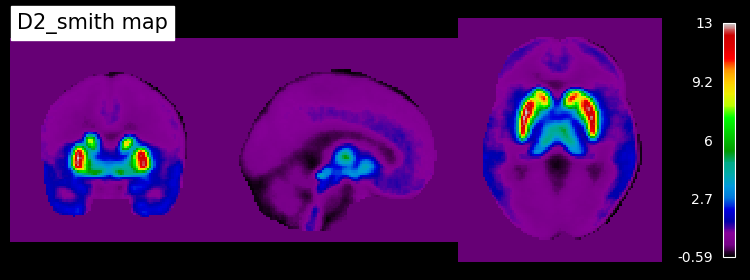

In [9]:
# Visualize the D2_smith map.
plot_epi(D2_smith_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="D2_smith map")


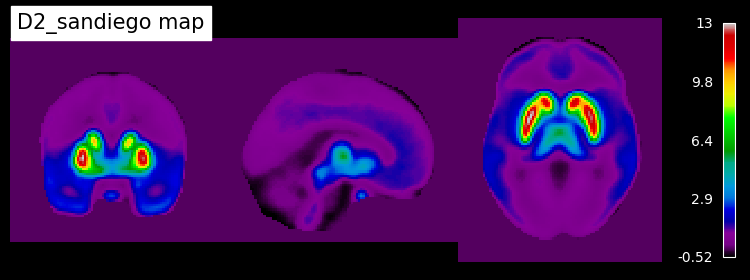

In [10]:
# Visualize the D2_sandiego map.
plot_epi(D2_sandiego_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="D2_sandiego map")


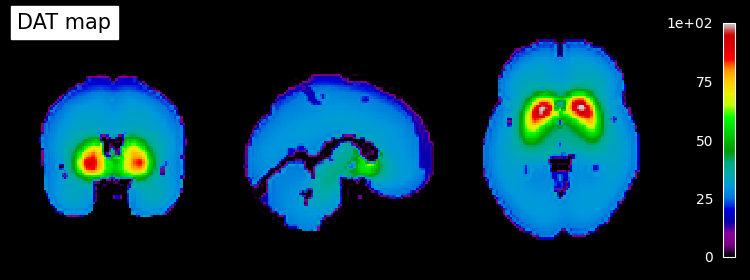

In [11]:
# Visualize the DAT map.
plot_epi(DAT_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="DAT map")

### Norepinephrine Maps

In [12]:
# Define paths to Hassen files for norepinephrine neurotransmitters. 
path_NAT = "GitHub/hansen_receptors/data/PET_nifti_images/NAT_MRB_hc77_ding.nii.gz"

# Create Brain_data objects for each file. 
NAT_map = Brain_Data(path_NAT).to_nifti()

# Check the shape of each file.
print("NAT_map shape: " + str(NAT_map.shape))

NAT_map shape: (91, 109, 91)


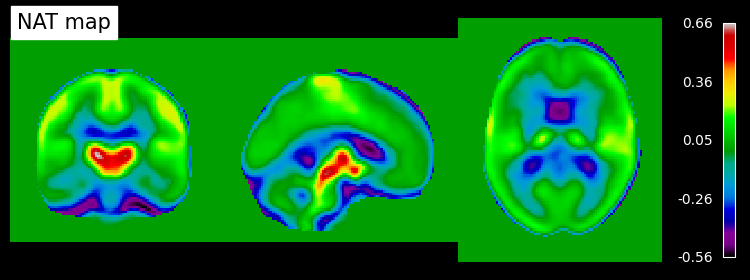

In [13]:
# Visualize the NAT map.
plot_epi(NAT_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="NAT map")

### Glutamate Maps

In [14]:
# Define paths to Hassen files for dopamine neurotransmitters. 
path_mGlu = "GitHub/hansen_receptors/data/PET_nifti_images/mGluR5_abp_hc73_smart.nii"
path_NMDA = "GitHub/hansen_receptors/data/PET_nifti_images/NMDA_ge179_hc29_galovic.nii.gz"

# Create Brain_data objects for each file. 
mGlu_map = Brain_Data(path_mGlu).to_nifti()
NMDA_map = Brain_Data(path_NMDA).to_nifti()

# Check the shape of each file.
print("mGlu_map shape: " + str(mGlu_map.shape))
print("NMDA_map shape: " + str(NMDA_map.shape))


mGlu_map shape: (91, 109, 91)
NMDA_map shape: (91, 109, 91)


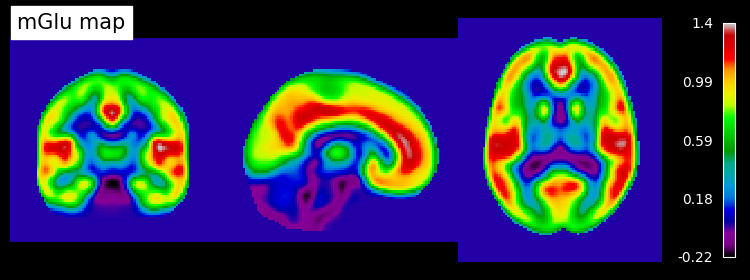

In [15]:
# Visualize the mGlu map.
plot_epi(mGlu_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="mGlu map")

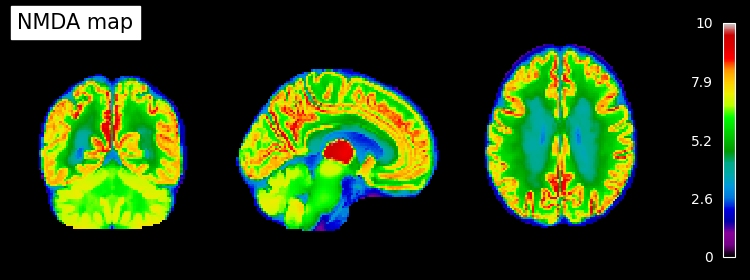

In [16]:
# Visualize the NMDA map.
plot_epi(NMDA_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="NMDA map")

### GABA Maps

In [17]:
# Define paths to Hassen files for GABA neurotransmitters. 
path_GABAa = "GitHub/hansen_receptors/data/PET_nifti_images/GABAa_flumazenil_hc6_dukart.nii"
path_GABAbz = "GitHub/hansen_receptors/data/PET_nifti_images/GABAa-bz_flumazenil_hc16_norgaard.nii"

# Create Brain_data objects for each file. 
GABAa_map = Brain_Data(path_GABAa).to_nifti()
GABAbz_map = Brain_Data(path_GABAbz).to_nifti()

# Check the shape of each file.
print("GABAa shape: " + str(GABAa_map.shape))
print("GABAbz shape: " + str(GABAbz_map.shape))

GABAa shape: (91, 109, 91)
GABAbz shape: (91, 109, 91)


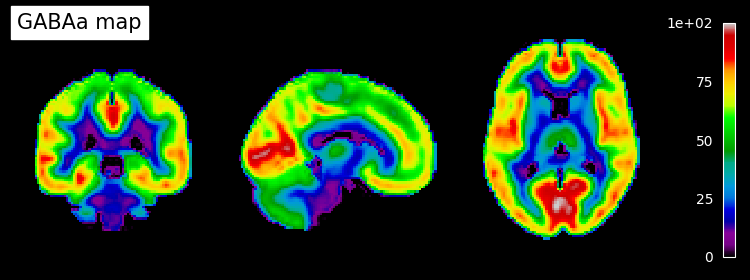

In [18]:
# Visualize the GABAa map.
plot_epi(GABAa_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="GABAa map")

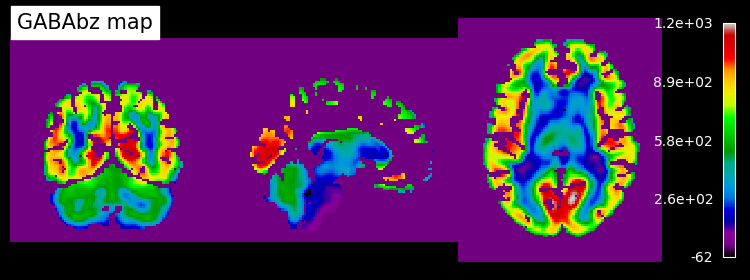

In [19]:
# Visualize the GABAbz map.
plot_epi(GABAbz_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="GABAbz map")

## Display AA Results

In [20]:
# Load the AAL atlas from nilearn.
AA = datasets.fetch_atlas_aal()

# Store atlas info.
AA_maps = AA.maps 

AA_labels = AA.labels

AA_indices = AA.indices

print("AA_labels: " + str(AA_labels))
print("AA_indices: " + str(AA_indices))

AA_labels: ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusif

In [21]:
# Get AAL COC-PLA change scores csv file. 
Change_PC1_AA_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/AAFIT_GM_PC1_ChangeScores.csv', index_col=0) 

# Calculate mean change score for each region.
Change_PC1_AA_mean_scores = Change_PC1_AA_scores_df.mean(axis=0, skipna=True)
Change_PC1_AA_std_scores = Change_PC1_AA_scores_df.std(axis=0, skipna=True)

# Sort Dataframe by highest to lowest change values. 
Change_PC1_AA_mean_scores.sort_values(axis=0, inplace=True, ascending=False)
Change_PC1_AA_std_scores.sort_values(axis=0, inplace=True, ascending=False)


In [22]:
# Show top 5 ROIs with most positive avg change score.
print("For the AAL atlas, the 5 ROIs with the highest positive avg change score were:")
print(Change_PC1_AA_mean_scores[0:5])

For the AAL atlas, the 5 ROIs with the highest positive avg change score were:
Frontal_Med_Orb_L    0.043274
Frontal_Med_Orb_R    0.036817
Precuneus_L          0.034517
Olfactory_R          0.027325
Angular_L            0.026870
dtype: float64


In [23]:
# Show top 5 ROIs with most negative avg change score.
print("For the AAL atlas, the 5 ROIs with the highest negative avg change score were:")
print(Change_PC1_AA_mean_scores[91:96])


For the AAL atlas, the 5 ROIs with the highest negative avg change score were:
Vermis_6        -0.047759
Fusiform_L      -0.050349
Cerebelum_9_R   -0.050559
Precentral_R    -0.051100
Vermis_7        -0.051513
dtype: float64


In [24]:
# Show top 5 ROIs with the highest std change score.
print("For the AAL atlas, the 5 ROIs with the highest std change score were:")
print(Change_PC1_AA_std_scores[0:5])

For the AAL atlas, the 5 ROIs with the highest std change score were:
Vermis_8             0.206226
Vermis_10            0.196093
Cerebelum_10_L       0.185810
Cerebelum_Crus2_L    0.184835
Vermis_7             0.183346
dtype: float64


In [25]:
# Show top 5 ROIs with the weakest std change score.
print("For the AAL atlas, the 5 ROIs with the weakest std change score were:")
print(Change_PC1_AA_std_scores[91:96])


For the AAL atlas, the 5 ROIs with the weakest std change score were:
Parietal_Inf_L    0.094171
Pallidum_L        0.093754
Postcentral_L     0.092983
Temporal_Sup_L    0.091903
Precentral_R      0.091255
dtype: float64


In [47]:
# Load nii files. 
AAL_COC_AVG_PC_path = "GitHub/ResearchElective_Maastricht2023/AA_AveragePC1Scores_COC.nii.gz"
AAL_COC_STD_PC_path = "GitHub/ResearchElective_Maastricht2023/AA_StdPC1Scores_COC.nii.gz"
AAL_PLA_AVG_PC_path = "GitHub/ResearchElective_Maastricht2023/AA_AveragePC1Scores_PLA.nii.gz"
AAL_PLA_STD_PC_path = "GitHub/ResearchElective_Maastricht2023/AA_StdPC1Scores_PLA.nii.gz"
AAL_PC_AVG_Change_path = "GitHub/ResearchElective_Maastricht2023/AA_AveragePC1Scores_Change.nii.gz"
AAL_PC_STD_Change_path = "GitHub/ResearchElective_Maastricht2023/AA_STDPC1Scores_Change.nii.gz"

AAL_COC_AVG_PC_file = nib.load(AAL_COC_AVG_PC_path)
AAL_COC_STD_PC_file = nib.load(AAL_COC_STD_PC_path)
AAL_PLA_AVG_PC_file = nib.load(AAL_PLA_AVG_PC_path)
AAL_PLA_STD_PC_file = nib.load(AAL_PLA_STD_PC_path)
AAL_PC_AVG_Change_file = nib.load(AAL_PC_AVG_Change_path)
AAL_PC_STD_Change_file = nib.load(AAL_PC_STD_Change_path)


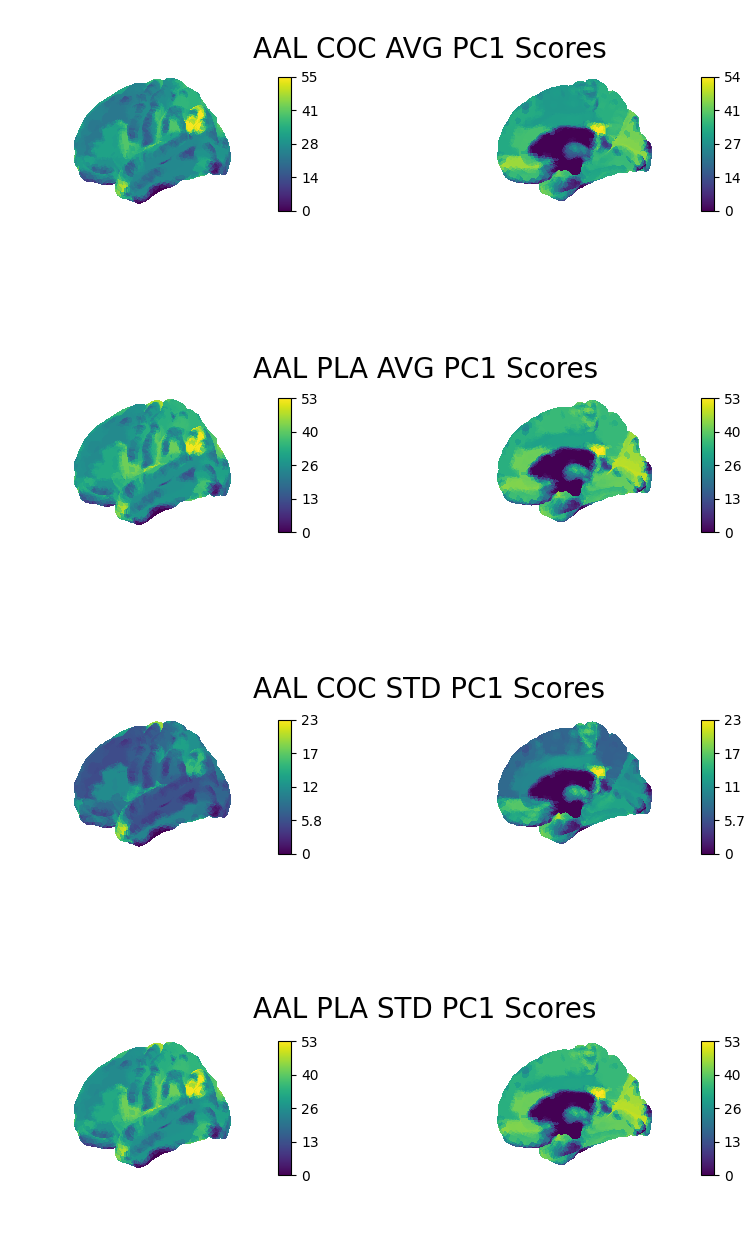

In [27]:
# Show brain maps for COC and PLA (AVG & STD). 

all_titles = ['AAL COC AVG PC1 Scores', 'AAL PLA AVG PC1 Scores', 'AAL COC STD PC1 Scores', 'AAL PLA STD PC1 Scores']

plot_brainmaps_results(AAL_COC_AVG_PC_file, AAL_COC_STD_PC_file, AAL_PLA_AVG_PC_file, AAL_PLA_STD_PC_file, all_titles)


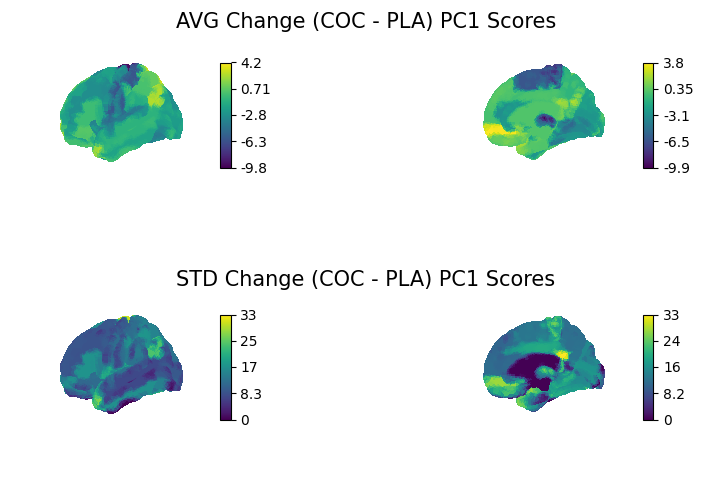

In [28]:
# Show change score brain map (COC - PLA mean change score). 

AAL_Change_titles = ["AVG Change (COC - PLA) PC1 Scores", "STD Change (COC - PLA) PC1 Scores"]

plotting_brainmaps_change(AAL_PC_AVG_Change_file, AAL_PC_STD_Change_file, AAL_Change_titles)

## Compare Neurotransmitter Densities to AA map 

In [29]:
# Compute a mask for each parcel in the AAL atlas. 
aal_roi_masks = []

for x in range(116):
    
    print("Computing and plotting roi_" +str(x) +": " + str(AA_labels[x]))
    roi_img =nl.image.new_img_like(AA_maps, nl.image.get_data(AA_maps) == int(AA_indices[x]))
    masker = NiftiMasker(mask_img=roi_img, mask_strategy="gm-template", verbose=False).fit()
    aal_roi_masks.append(masker)
    

Computing and plotting roi_0: Precentral_L
Computing and plotting roi_1: Precentral_R
Computing and plotting roi_2: Frontal_Sup_L
Computing and plotting roi_3: Frontal_Sup_R
Computing and plotting roi_4: Frontal_Sup_Orb_L
Computing and plotting roi_5: Frontal_Sup_Orb_R
Computing and plotting roi_6: Frontal_Mid_L
Computing and plotting roi_7: Frontal_Mid_R
Computing and plotting roi_8: Frontal_Mid_Orb_L
Computing and plotting roi_9: Frontal_Mid_Orb_R
Computing and plotting roi_10: Frontal_Inf_Oper_L
Computing and plotting roi_11: Frontal_Inf_Oper_R
Computing and plotting roi_12: Frontal_Inf_Tri_L
Computing and plotting roi_13: Frontal_Inf_Tri_R
Computing and plotting roi_14: Frontal_Inf_Orb_L
Computing and plotting roi_15: Frontal_Inf_Orb_R
Computing and plotting roi_16: Rolandic_Oper_L
Computing and plotting roi_17: Rolandic_Oper_R
Computing and plotting roi_18: Supp_Motor_Area_L
Computing and plotting roi_19: Supp_Motor_Area_R
Computing and plotting roi_20: Olfactory_L
Computing and p

In [30]:
# Fit AAL to Hassen Neurotransmitters maps. 

D1_to_AAL_mean_scores = []
D2_smith_to_AAL_mean_scores = []
D2_sd_to_AAL_mean_scores = []
DAT_to_AAL_mean_scores = []
NAT_to_AAL_mean_scores = []
mGlu_to_AAL_mean_scores = []
NMDA_to_AAL_mean_scores = []
GABAa_to_AAL_mean_scores = []
GABAbz_to_AAL_mean_scores = []

for current_roi in range(116):

    D1_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], D1_map))
    D2_smith_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], D2_smith_map))
    D2_sd_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], D2_sandiego_map))
    DAT_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], DAT_map))
    NAT_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], NAT_map))
    mGlu_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], mGlu_map))
    NMDA_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], NMDA_map))
    GABAa_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], GABAa_map))
    GABAbz_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], GABAbz_map))
    




In [31]:
# Compute correlation between Hassen maps and AAL AVG PC1 scores 
D1_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, D1_to_AAL_mean_scores)
D2_smith_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, D2_smith_to_AAL_mean_scores)
D2_sd_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, D2_sd_to_AAL_mean_scores)
DAT_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, DAT_to_AAL_mean_scores)

NAT_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, NAT_to_AAL_mean_scores)
mGlu_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, mGlu_to_AAL_mean_scores)
NMDA_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, NMDA_to_AAL_mean_scores)
GABAa_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, GABAa_to_AAL_mean_scores)
GABAbz_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, GABAbz_to_AAL_mean_scores)

print("Correlation between D1 map and AAL PC1 scores: r=%3f, p-value=%3f" % (D1_AAl_cor[0], D1_AAl_cor[1])) 
print("Correlation between D2_smith map and AAL PC1 scores: r=%3f, p-value=%3f" % (D2_smith_AAl_cor[0], D2_smith_AAl_cor[1])) 
print("Correlation between D2_sd and AAL PC1 scores: r=%3f, p-value=%3f" % (D2_sd_AAl_cor[0], D2_sd_AAl_cor[1])) 
print("Correlation between DAT map and AAL PC1 scores: r=%3f, p-value=%3f" % (DAT_AAl_cor[0], DAT_AAl_cor[1])) 

print("Correlation between NAT map and AAL PC1 scores: r=%3f, p-value=%3f" % (NAT_AAl_cor[0], NAT_AAl_cor[1])) 
print("Correlation between mGlu map and AAL PC1 scores: r=%3f, p-value=%3f" % (mGlu_AAl_cor[0], mGlu_AAl_cor[1])) 
print("Correlation between NMDA map and AAL PC1 scores: r=%3f, p-value=%3f" % (NMDA_AAl_cor[0], NMDA_AAl_cor[1])) 
print("Correlation between GABAa map and AAL PC1 scores: r=%3f, p-value=%3f" % (GABAa_AAl_cor[0], GABAa_AAl_cor[1])) 
print("Correlation between GABAbz map and AAL PC1 scores: r=%3f, p-value=%3f" % (GABAbz_AAl_cor[0], GABAbz_AAl_cor[1]))

Correlation between D1 map and AAL PC1 scores: r=0.305420, p-value=0.000856
Correlation between D2_smith map and AAL PC1 scores: r=0.112406, p-value=0.229614
Correlation between D2_sd and AAL PC1 scores: r=0.072019, p-value=0.442330
Correlation between DAT map and AAL PC1 scores: r=0.061146, p-value=0.514378
Correlation between NAT map and AAL PC1 scores: r=0.268778, p-value=0.003530
Correlation between mGlu map and AAL PC1 scores: r=0.696664, p-value=0.000000
Correlation between NMDA map and AAL PC1 scores: r=0.183008, p-value=0.049258
Correlation between GABAa map and AAL PC1 scores: r=0.518453, p-value=0.000000
Correlation between GABAbz map and AAL PC1 scores: r=0.480299, p-value=0.000000


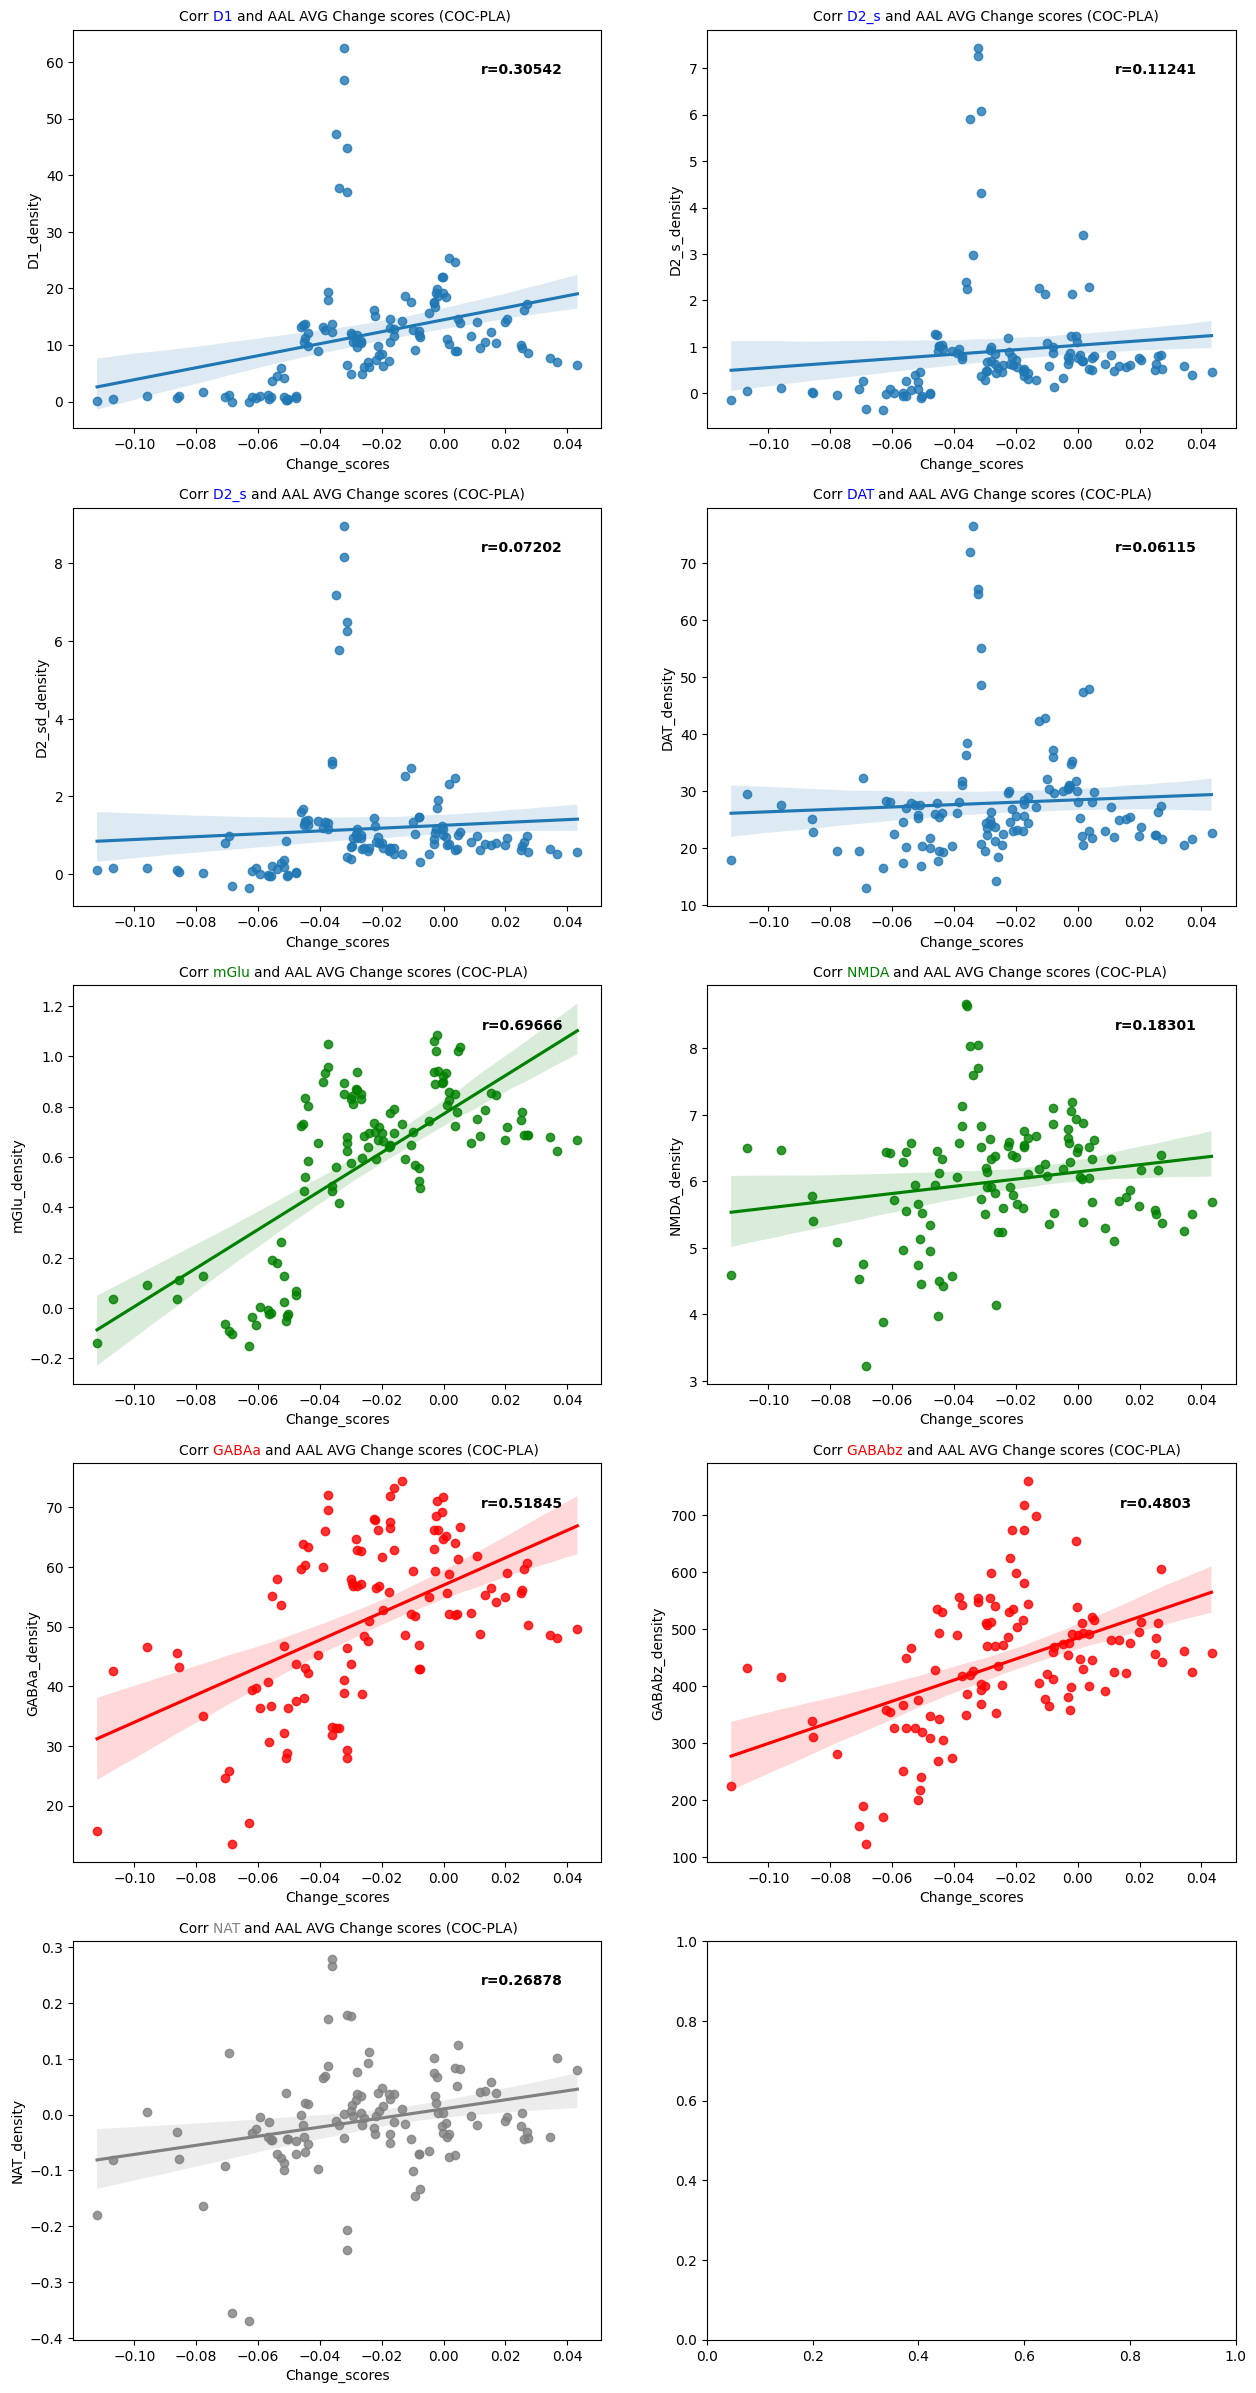

In [32]:
import matplotlib as mpl

mpl.rcParams['figure.facecolor'] = 'w'


all_data_AAL = np.array([Change_PC1_AA_mean_scores, D1_to_AAL_mean_scores, D2_smith_to_AAL_mean_scores, D2_sd_to_AAL_mean_scores, DAT_to_AAL_mean_scores,
                        NAT_to_AAL_mean_scores, mGlu_to_AAL_mean_scores, NMDA_to_AAL_mean_scores, GABAa_to_AAL_mean_scores, GABAbz_to_AAL_mean_scores])

Neurotransmitters_AAl_scores = pd.DataFrame(data=all_data_AAL.T, columns=["Change_scores", "D1_density", "D2_s_density", "D2_sd_density", "DAT_density", "NAT_density", 
                                                                          "mGlu_density", "NMDA_density", "GABAa_density", "GABAbz_density"])

aal_hassen_correlation_lists = [D1_AAl_cor, D2_smith_AAl_cor, D2_sd_AAl_cor, DAT_AAl_cor, mGlu_AAl_cor, NMDA_AAl_cor, GABAa_AAl_cor, GABAbz_AAl_cor, NAT_AAl_cor]

plot_correlations(Neurotransmitters_AAl_scores, aal_hassen_correlation_lists, "AVG Change scores (COC-PLA)")



In [33]:
# Compute correlation between Hassen maps and AAL STD PC1 scores 
D1_AAl_std_cor = pearsonr(Change_PC1_AA_std_scores, D1_to_AAL_mean_scores)
D2_smith_AAl_std_cor = pearsonr(Change_PC1_AA_std_scores, D2_smith_to_AAL_mean_scores)
D2_sd_AAl_std_cor = pearsonr(Change_PC1_AA_std_scores, D2_sd_to_AAL_mean_scores)
DAT_AAl_std_cor = pearsonr(Change_PC1_AA_std_scores, DAT_to_AAL_mean_scores)

NAT_AAl_std_cor = pearsonr(Change_PC1_AA_std_scores, NAT_to_AAL_mean_scores)
mGlu_AAl_std_cor = pearsonr(Change_PC1_AA_std_scores, mGlu_to_AAL_mean_scores)
NMDA_AAl_std_cor = pearsonr(Change_PC1_AA_std_scores, NMDA_to_AAL_mean_scores)
GABAa_AAl_std_cor = pearsonr(Change_PC1_AA_std_scores, GABAa_to_AAL_mean_scores)
GABAbz_AAl_std_cor = pearsonr(Change_PC1_AA_std_scores, GABAbz_to_AAL_mean_scores)

print("Correlation between D1 map and AAL STD PC1 scores: r=%3f, p-value=%3f" % (D1_AAl_std_cor[0], D1_AAl_std_cor[1])) 
print("Correlation between D2_smith map and AAL STD PC1 scores: r=%3f, p-value=%3f" % (D2_smith_AAl_std_cor[0], D2_smith_AAl_std_cor[1])) 
print("Correlation between D2_sd and AAL STD PC1 scores: r=%3f, p-value=%3f" % (D2_sd_AAl_std_cor[0], D2_sd_AAl_std_cor[1])) 
print("Correlation between DAT map and AAL STD PC1 scores: r=%3f, p-value=%3f" % (DAT_AAl_std_cor[0], DAT_AAl_std_cor[1])) 

print("Correlation between NAT map and AAL STD PC1 scores: r=%3f, p-value=%3f" % (NAT_AAl_std_cor[0], NAT_AAl_std_cor[1])) 
print("Correlation between mGlu map and AAL STD PC1 scores: r=%3f, p-value=%3f" % (mGlu_AAl_std_cor[0], mGlu_AAl_std_cor[1])) 
print("Correlation between NMDA map and AAL STD PC1 scores: r=%3f, p-value=%3f" % (NMDA_AAl_std_cor[0], NMDA_AAl_std_cor[1])) 
print("Correlation between GABAa map and AAL STD PC1 scores: r=%3f, p-value=%3f" % (GABAa_AAl_std_cor[0], GABAa_AAl_std_cor[1])) 
print("Correlation between GABAbz map and AAL STD PC1 scores: r=%3f, p-value=%3f" % (GABAbz_AAl_std_cor[0], GABAbz_AAl_std_cor[1]))

Correlation between D1 map and AAL STD PC1 scores: r=0.217724, p-value=0.018885
Correlation between D2_smith map and AAL STD PC1 scores: r=0.050296, p-value=0.591837
Correlation between D2_sd and AAL STD PC1 scores: r=0.010151, p-value=0.913876
Correlation between DAT map and AAL STD PC1 scores: r=0.000024, p-value=0.999796
Correlation between NAT map and AAL STD PC1 scores: r=0.230170, p-value=0.012932
Correlation between mGlu map and AAL STD PC1 scores: r=0.589080, p-value=0.000000
Correlation between NMDA map and AAL STD PC1 scores: r=0.117778, p-value=0.207972
Correlation between GABAa map and AAL STD PC1 scores: r=0.437341, p-value=0.000001
Correlation between GABAbz map and AAL STD PC1 scores: r=0.430127, p-value=0.000001


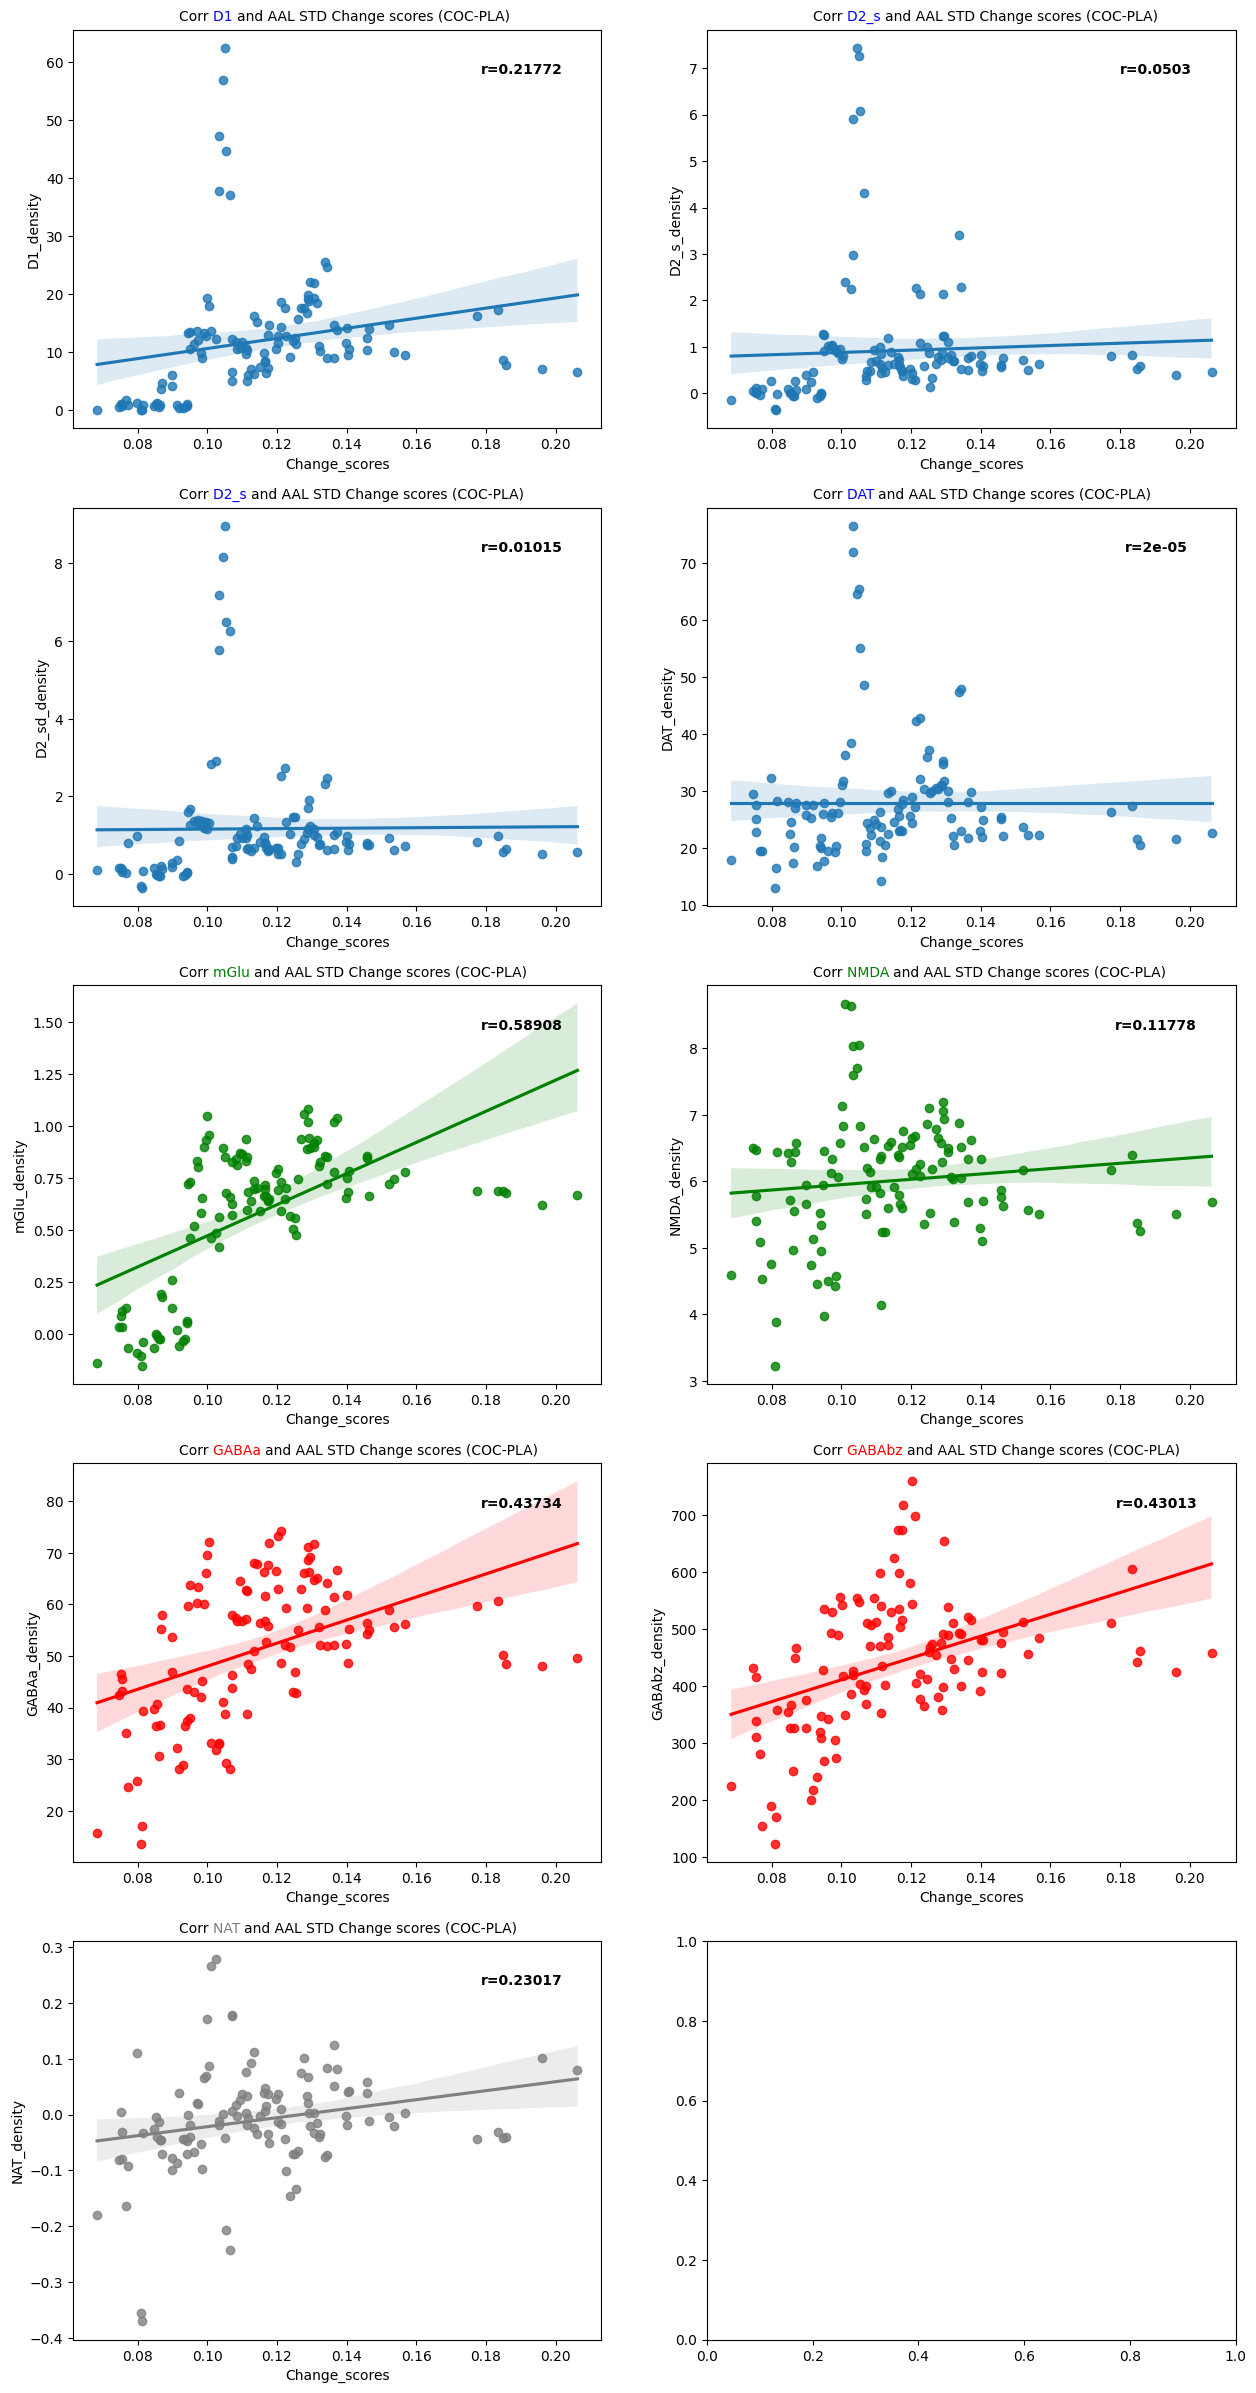

In [34]:
all_data_AAL_std = np.array([Change_PC1_AA_std_scores, D1_to_AAL_mean_scores, D2_smith_to_AAL_mean_scores, D2_sd_to_AAL_mean_scores, DAT_to_AAL_mean_scores,
                        NAT_to_AAL_mean_scores, mGlu_to_AAL_mean_scores, NMDA_to_AAL_mean_scores, GABAa_to_AAL_mean_scores, GABAbz_to_AAL_mean_scores])

Neurotransmitters_AAl_std_scores = pd.DataFrame(data=all_data_AAL_std.T, columns=["Change_scores", "D1_density", "D2_s_density", "D2_sd_density", "DAT_density", "NAT_density", 
                                                                          "mGlu_density", "NMDA_density", "GABAa_density", "GABAbz_density"])

aal_hassen_correlation_lists_std = [D1_AAl_std_cor, D2_smith_AAl_std_cor, D2_sd_AAl_std_cor, DAT_AAl_std_cor, mGlu_AAl_std_cor, NMDA_AAl_std_cor, GABAa_AAl_std_cor, GABAbz_AAl_std_cor, NAT_AAl_std_cor]

plot_correlations(Neurotransmitters_AAl_std_scores, aal_hassen_correlation_lists_std, "STD Change scores (COC-PLA)")

## Display Yeo Atlas (17 Networks) Results

## Compare Neurotransmitter Densities to Yeo Atlas (17 Networks) 

## Display RM Results

In [35]:
rm_data_path = "/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/GlebRM_rrm+thal-bg_1mm_20111013_uint8_dilated2-res.nii"
rm_info_path = "/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/RM_mni_description_20110513_PS.xlsx"

rm_maps = Brain_Data(rm_data_path).to_nifti()

In [36]:
# Read info from exel file. 
rm_info = pd.read_excel(rm_info_path, index_col=None) 

rm_labels = rm_info["areaCaret"]
rm_idx = rm_info["niftiValue"]

print("Number of lables in rm atlas: " + str(len(rm_labels)))
print("Number of idx in rm atlas: " + str(len(rm_idx)))

Number of lables in rm atlas: 96
Number of idx in rm atlas: 96


In [42]:
# Get AAL COC-PLA change scores csv file. 
Change_PC1_RM_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/RMFIT_GM_PC1_ChangeScores.csv', index_col=0) 

# Calculate mean change score for each region.
Change_PC1_RM_mean_scores = Change_PC1_RM_scores_df.mean(axis=0, skipna=True)
Change_PC1_RM_std_scores = Change_PC1_RM_scores_df.std(axis=0, skipna=True)

# Sort Dataframe by highest to lowest change values. 
Change_PC1_RM_mean_scores.sort_values(axis=0, inplace=True, ascending=False)
Change_PC1_RM_std_scores.sort_values(axis=0, inplace=True, ascending=False)


In [43]:
# Show top 5 ROIs with most positive avg change score.
print("For the RM atlas, the 5 ROIs with the highest positive avg change score were:")
print(Change_PC1_RM_mean_scores[0:5])

For the RM atlas, the 5 ROIs with the highest positive avg change score were:
PCm.1       0.046844
CCr.1       0.036823
PFCpol.1    0.035275
CCp.1       0.033977
INSa        0.031004
dtype: float64


In [44]:
# Show top 5 ROIs with most negative avg change score.
print("For the RM atlas, the 5 ROIs with the highest negative avg change score were:")
print(Change_PC1_RM_mean_scores[91:96])


For the RM atlas, the 5 ROIs with the highest negative avg change score were:
BG-caud       -0.091225
M1.1          -0.091551
Thal-Front    -0.101744
Thal-Temp.1   -0.101811
Thal-Temp     -0.104248
dtype: float64


In [45]:
# Show top 5 ROIs with the highest std change score.
print("For the RM atlas, the 5 ROIs with the highest std change score were:")
print(Change_PC1_RM_std_scores[0:5])

For the RM atlas, the 5 ROIs with the highest std change score were:
V1-right      0.161261
V1-left       0.157620
VACv          0.154340
Thal-Front    0.152380
TCv           0.145954
dtype: float64


In [46]:
# Show top 5 ROIs with the weakest std change score.
print("For the RM atlas, the 5 ROIs with the weakest std change score were:")
print(Change_PC1_RM_std_scores[91:96])

For the RM atlas, the 5 ROIs with the weakest std change score were:
PCi        0.066671
PMCvl.1    0.063703
FEF.1      0.063428
CCp        0.062550
TCs.1      0.060429
dtype: float64


## Compare Neurotransmitter Densities to RM Atlas 

In [38]:
RM_roi_masks = []

for x in range(len(rm_labels)):

    try:
        print("Computing and plotting roi_" +str(x) +": " + str(rm_labels[x]))
        roi_img = nl.image.new_img_like(rm_maps, nl.image.get_data(rm_maps) == rm_idx[x])
        masker = NiftiMasker(mask_img=roi_img, mask_strategy="gm-template", verbose=False).fit() 
        RM_roi_masks.append(masker)

    except FileNotFoundError:
        print("Problem with roi_" +str(x) + " " + str(rm_labels[x]))

Computing and plotting roi_0: TCpol
Computing and plotting roi_1: TCs
Computing and plotting roi_2: Amyg
Computing and plotting roi_3: OFCi
Computing and plotting roi_4: INSa
Computing and plotting roi_5: OFCm
Computing and plotting roi_6: TCc
Computing and plotting roi_7: OFCl
Computing and plotting roi_8: TCi
Computing and plotting roi_9: PHC
Computing and plotting roi_10: INS-G
Computing and plotting roi_11: PMCvl
Computing and plotting roi_12: VACv
Computing and plotting roi_13: INSp
Computing and plotting roi_14: PFCpol
Computing and plotting roi_15: HIP
Computing and plotting roi_16: sACC
Computing and plotting roi_17: PFCvl
Computing and plotting roi_18: V2
Computing and plotting roi_19: PFCm
Computing and plotting roi_20: TCv
Computing and plotting roi_21: VACd
Computing and plotting roi_22: V1-right
Computing and plotting roi_23: PFCcl
Computing and plotting roi_24: A2
Computing and plotting roi_25: CCr
Computing and plotting roi_26: CCp
Computing and plotting roi_27: ACC
Comp

In [39]:
# Fit RM to Hassen Neurotransmitters maps. 
D1_to_RM_mean_scores = []
D2_smith_to_RM_mean_scores = []
D2_sd_to_RM_mean_scores = []
DAT_to_RM_mean_scores = []
NAT_to_RM_mean_scores = []
mGlu_to_RM_mean_scores = []
NMDA_to_RM_mean_scores = []
GABAa_to_RM_mean_scores = []
GABAbz_to_RM_mean_scores = []

for current_roi in range(96):

    D1_to_RM_mean_scores.append(fit_mask_get_mean(RM_roi_masks[current_roi], D1_map))
    D2_smith_to_RM_mean_scores.append(fit_mask_get_mean(RM_roi_masks[current_roi], D2_smith_map))
    D2_sd_to_RM_mean_scores.append(fit_mask_get_mean(RM_roi_masks[current_roi], D2_sandiego_map))
    DAT_to_RM_mean_scores.append(fit_mask_get_mean(RM_roi_masks[current_roi], DAT_map))
    NAT_to_RM_mean_scores.append(fit_mask_get_mean(RM_roi_masks[current_roi], NAT_map))
    mGlu_to_RM_mean_scores.append(fit_mask_get_mean(RM_roi_masks[current_roi], mGlu_map))
    NMDA_to_RM_mean_scores.append(fit_mask_get_mean(RM_roi_masks[current_roi], NMDA_map))
    GABAa_to_RM_mean_scores.append(fit_mask_get_mean(RM_roi_masks[current_roi], GABAa_map))
    GABAbz_to_RM_mean_scores.append(fit_mask_get_mean(RM_roi_masks[current_roi], GABAbz_map))
    

In [40]:
# Compute correlation between Hassen maps and AAL PC1 scores 
D1_RM_cor = pearsonr(Change_PC1_RM_mean_scores, D1_to_RM_mean_scores)
D2_smith_RM_cor = pearsonr(Change_PC1_RM_mean_scores, D2_smith_to_RM_mean_scores)
D2_sd_RM_cor = pearsonr(Change_PC1_RM_mean_scores, D2_sd_to_RM_mean_scores)
DAT_RM_cor = pearsonr(Change_PC1_RM_mean_scores, DAT_to_RM_mean_scores)

NAT_RM_cor = pearsonr(Change_PC1_RM_mean_scores, NAT_to_RM_mean_scores)
mGlu_RM_cor = pearsonr(Change_PC1_RM_mean_scores, mGlu_to_RM_mean_scores)
NMDA_RM_cor = pearsonr(Change_PC1_RM_mean_scores, NMDA_to_RM_mean_scores)
GABAa_RM_cor = pearsonr(Change_PC1_RM_mean_scores, GABAa_to_RM_mean_scores)
GABAbz_RM_cor = pearsonr(Change_PC1_RM_mean_scores, GABAbz_to_RM_mean_scores)

print("Correlation between D1 map and RM PC1 scores: r=%3f, p-value=%3f" % (D1_RM_cor[0], D1_RM_cor[1])) 
print("Correlation between D2_smith map and RM PC1 scores: r=%3f, p-value=%3f" % (D2_smith_RM_cor[0], D2_smith_RM_cor[1])) 
print("Correlation between D2_sd and RM PC1 scores: r=%3f, p-value=%3f" % (D2_sd_RM_cor[0], D2_sd_RM_cor[1])) 
print("Correlation between DAT map and RM PC1 scores: r=%3f, p-value=%3f" % (DAT_RM_cor[0], DAT_RM_cor[1])) 

print("Correlation between NAT map and RM PC1 scores: r=%3f, p-value=%3f" % (NAT_RM_cor[0], NAT_RM_cor[1])) 
print("Correlation between mGlu map and RM PC1 scores: r=%3f, p-value=%3f" % (mGlu_RM_cor[0], mGlu_RM_cor[1])) 
print("Correlation between NMDA map and RM PC1 scores: r=%3f, p-value=%3f" % (NMDA_RM_cor[0], NMDA_RM_cor[1])) 
print("Correlation between GABAa map and RM PC1 scores: r=%3f, p-value=%3f" % (GABAa_RM_cor[0], GABAa_RM_cor[1])) 
print("Correlation between GABAbz map and RM PC1 scores: r=%3f, p-value=%3f" % (GABAbz_RM_cor[0], GABAbz_RM_cor[1]))

Correlation between D1 map and RM PC1 scores: r=-0.198653, p-value=0.052345
Correlation between D2_smith map and RM PC1 scores: r=-0.185270, p-value=0.070735
Correlation between D2_sd and RM PC1 scores: r=-0.197586, p-value=0.053650
Correlation between DAT map and RM PC1 scores: r=-0.208535, p-value=0.041457
Correlation between NAT map and RM PC1 scores: r=-0.102927, p-value=0.318320
Correlation between mGlu map and RM PC1 scores: r=0.001657, p-value=0.987216
Correlation between NMDA map and RM PC1 scores: r=-0.122103, p-value=0.235967
Correlation between GABAa map and RM PC1 scores: r=0.039415, p-value=0.702998
Correlation between GABAbz map and RM PC1 scores: r=0.032952, p-value=0.749936


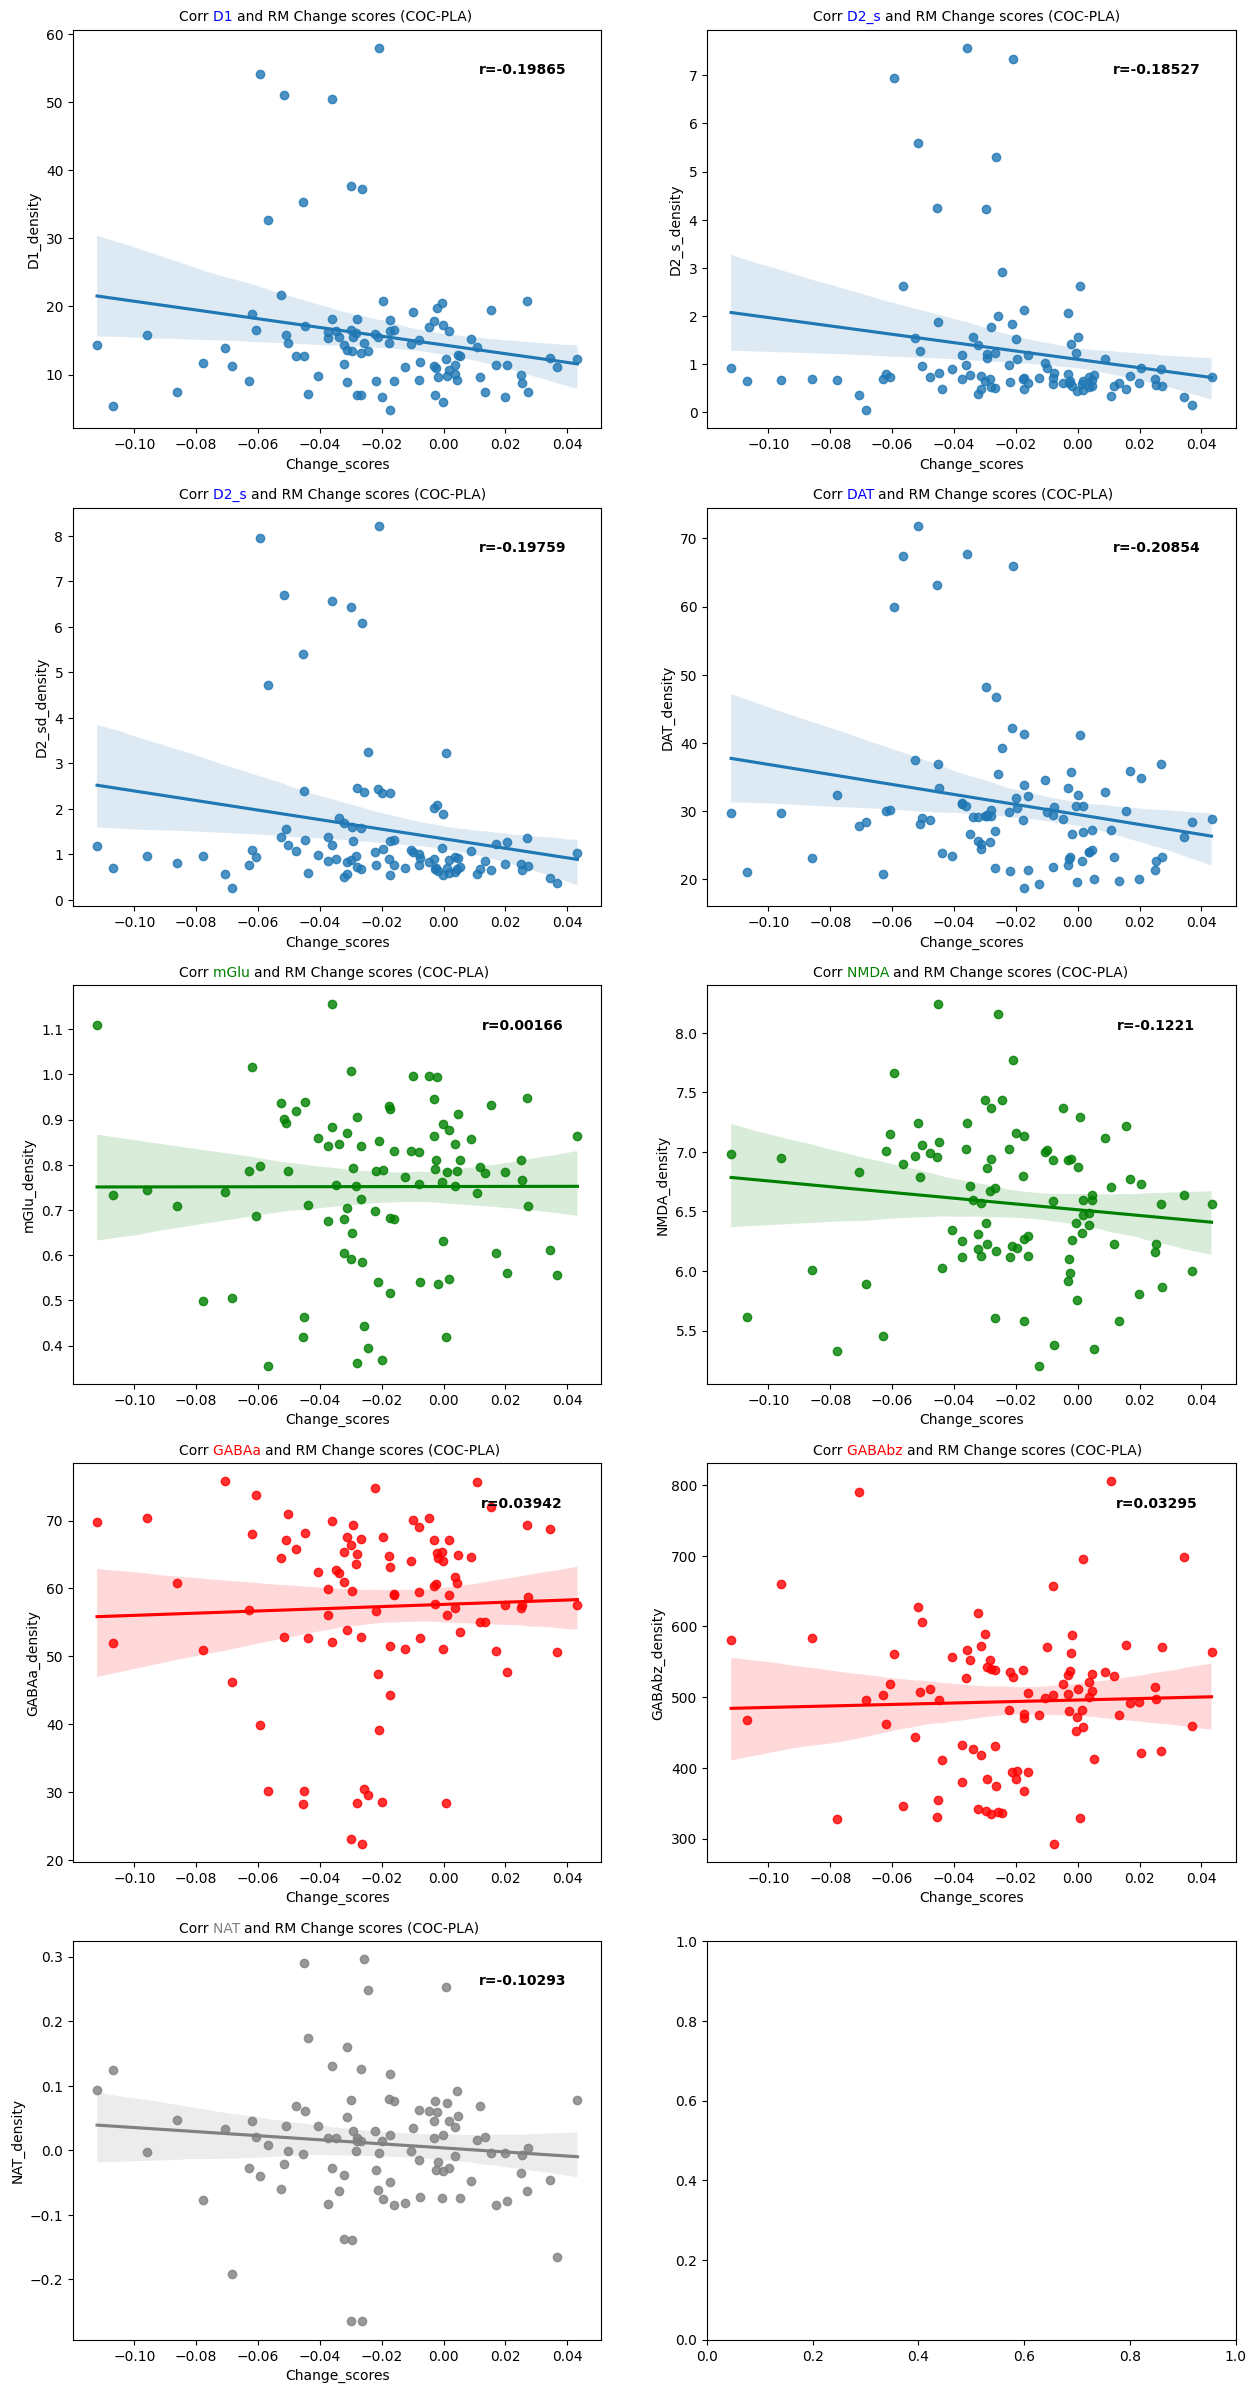

In [41]:
all_data_RM = np.array([Change_PC1_RM_mean_scores, D1_to_RM_mean_scores, D2_smith_to_RM_mean_scores, D2_sd_to_RM_mean_scores, DAT_to_RM_mean_scores,
                        NAT_to_RM_mean_scores, mGlu_to_RM_mean_scores, NMDA_to_RM_mean_scores, GABAa_to_RM_mean_scores, GABAbz_to_RM_mean_scores])

Neurotransmitters_RM_scores = pd.DataFrame(data=all_data_RM.T, columns=["Change_scores", "D1_density", "D2_s_density", "D2_sd_density", "DAT_density", "NAT_density", 
                                                                          "mGlu_density", "NMDA_density", "GABAa_density", "GABAbz_density"])

fig, ax = plt.subplots(5, 2, figsize=(15, 30))

regplot_D1 = sns.regplot(data=Neurotransmitters_RM_scores, x="Change_scores", y="D1_density", ax=ax[0, 0])
title1 = "Corr <color:blue>D1 </>and RM Change scores (COC-PLA)"
flexitext(0.2, 1.05, title1, va="top", ax=ax[0, 0])
r_value1 = "<weight:bold, size:10>r="+str(round(D1_RM_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value1, ha="center", ax=ax[0, 0])

regplot_D2_s = sns.regplot(data=Neurotransmitters_RM_scores, x="Change_scores", y="D2_s_density", ax=ax[0, 1])
title2 = "Corr <color:blue>D2_s </>and RM Change scores (COC-PLA)"
flexitext(0.2, 1.05, title2, va="top", ax=ax[0, 1])
r_value2 = "<weight:bold, size:10>r="+str(round(D2_smith_RM_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value2, ha="center", ax=ax[0, 1])

regplot_D2_sd = sns.regplot(data=Neurotransmitters_RM_scores, x="Change_scores", y="D2_sd_density", ax=ax[1, 0])
title3 = "Corr <color:blue>D2_s </>and RM Change scores (COC-PLA)"
flexitext(0.2, 1.05, title3, va="top", ax=ax[1, 0])
r_value3 = "<weight:bold, size:10>r="+str(round(D2_sd_RM_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value3, ha="center", ax=ax[1, 0])

regplot_DAT = sns.regplot(data=Neurotransmitters_RM_scores, x="Change_scores", y="DAT_density", ax=ax[1, 1])
title4 = "Corr <color:blue>DAT </>and RM Change scores (COC-PLA)"
flexitext(0.2, 1.05, title4, va="top", ax=ax[1, 1])
r_value4 = "<weight:bold, size:10>r="+str(round(DAT_RM_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value4, ha="center", ax=ax[1, 1])

regplot_mGlu = sns.regplot(data=Neurotransmitters_RM_scores, x="Change_scores", y="mGlu_density", ax=ax[2, 0], color="green")
title5 = "Corr <color:green>mGlu </>and RM Change scores (COC-PLA)"
flexitext(0.2, 1.05, title5, va="top", ax=ax[2, 0])
r_value5 = "<weight:bold, size:10>r="+str(round(mGlu_RM_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value5, ha="center", ax=ax[2, 0])

regplot_NMDA = sns.regplot(data=Neurotransmitters_RM_scores, x="Change_scores", y="NMDA_density", ax=ax[2, 1], color="green")
title6 = "Corr <color:green>NMDA </>and RM Change scores (COC-PLA)"
flexitext(0.2, 1.05, title6, va="top", ax=ax[2, 1])
r_value6 = "<weight:bold, size:10>r="+str(round(NMDA_RM_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value6, ha="center", ax=ax[2, 1])

regplot_mGlu = sns.regplot(data=Neurotransmitters_RM_scores, x="Change_scores", y="GABAa_density", ax=ax[3, 0], color="red") 
title7 = "Corr <color:red>GABAa </>and RM Change scores (COC-PLA)"
flexitext(0.2, 1.05, title7, va="top", ax=ax[3, 0])
r_value7 = "<weight:bold, size:10>r="+str(round(GABAa_RM_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value7, ha="center", ax=ax[3, 0])

regplot_NMDA = sns.regplot(data=Neurotransmitters_RM_scores, x="Change_scores", y="GABAbz_density", ax=ax[3, 1], color="red")
title8 = "Corr <color:red>GABAbz </>and RM Change scores (COC-PLA)"
flexitext(0.2, 1.05, title8, va="top", ax=ax[3, 1])
r_value8 = "<weight:bold, size:10>r="+str(round(GABAbz_RM_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value8, ha="center", ax=ax[3, 1])

regplot_NAT = sns.regplot(data=Neurotransmitters_RM_scores, x="Change_scores", y="NAT_density", ax=ax[4, 0], color="gray")
title9 = "Corr <color:gray>NAT </>and RM Change scores (COC-PLA)"
flexitext(0.2, 1.05, title9, va="top", ax=ax[4, 0])
r_value9 = "<weight:bold, size:10>r="+str(round(NAT_RM_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value9, ha="center", ax=ax[4, 0])

plt.show()